# In the name of God
### HW6
### Deep Q-Learning



**Name:** Javad Razi

**Std. No.:** 401204354


### Deep Q-Learning (DQN)

Deep Q-Learning is a popular algorithm in reinforcement learning that combines the ideas of Q-learning, a traditional reinforcement learning method, with deep neural networks. The goal is to train an agent to make decisions by estimating the optimal action-value function Q, which represents the expected cumulative future rewards for taking a particular action in a given state.

Key components of DQN:

- **Experience Replay:** To break the temporal correlation in sequential data and improve sample efficiency, we use an experience replay buffer to store and sample past experiences.
- **Target Networks:** The use of two separate networks, the main network and a target network, helps stabilize training by decoupling the update targets from the online network's constantly changing values.

### The Lunar Lander Problem

The task is to control a lunar lander and guide it to land safely on the moon's surface. The agent needs to learn a policy that takes into account the lunar lander's state (position, velocity, angle, angular velocity, etc.) and chooses appropriate actions (thrust left, thrust right, thrust up, or do nothing) to achieve a safe landing.

### Overview

- **Environment:** LunarLander-v2 from OpenAI Gym.
- **Objective:** Train an agent to learn a policy for landing the lunar lander safely.
- **Techniques:** Deep Q-Learning, Experience Replay, Target Networks.

### Instructions

1. Follow the instructions and comments in the code cells to implement and understand each component.
2. Replace the `#####TO DO#####` placeholders with your code.
3. Experiment with hyperparameters and observe how they affect the training process.
4. Run the notebook to train the agent and play the game with the trained model.
5. Answer any provided questions or tasks to reinforce your understanding.

### Prerequisites

Make sure you have the following libraries installed:


In [1]:
!pip install --upgrade setuptools wheel

In [2]:
!pip install swig
!pip install gym[box2d]

# Imports

In [3]:
import numpy as np
import gym
import time
import torch
import torch.nn as nn
import torch.optim as optim
import os
import collections
import matplotlib.pyplot as plt
import collections


env = gym.make('LunarLander-v2')

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [4]:
class DQN(nn.Module):
    def __init__(self, in_features, n_actions):
        """
        Initialize the Deep Q-Network (DQN).

        Parameters:
        - in_features (int): Number of input features (dimension of the state).
        - n_actions (int): Number of possible actions in the environment.
        """
        super(DQN, self).__init__()

        # Define the layers of the network
        self.layer1 = nn.Linear(in_features, 256)
        self.layer2 = nn.Linear(256, 128)
        self.layer3 = nn.Linear(128, 64)
        self.output_layer = nn.Linear(64, n_actions)

    def forward(self, state):
        """
        Define the forward pass of the network.

        Parameters:
        - state (torch.Tensor): The current state of the environment.

        Returns:
        - output (torch.Tensor): The Q-values for each action.
        """
        x = torch.relu(self.layer1(state))
        x = torch.relu(self.layer2(x))
        x = torch.relu(self.layer3(x))
        output = self.output_layer(x)
        return output


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [5]:
class DQN(nn.Module):
    def __init__(self, in_features, n_actions):
        super(DQN, self).__init__()

        self.fc1 = nn.Linear(in_features, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)

        # Output layer
        self.out = nn.Linear(64, n_actions)

    def forward(self, x):
        x = torch.relu(self.fc1(x))

        x = torch.relu(self.fc2(x))

        x = torch.relu(self.fc3(x))

        # Get the final output (Q-values for each action)
        return self.out(x)


In [6]:
class Agent():
    def __init__(self, env, buffer):
        self.env = env
        self.buffer = buffer
        self._reset()

    def _reset(self):
        self.state = self.env.reset()
        self.total_rewards = 0.0

    def step(self, net, eps, device="cpu"):
        done_reward = None

        # Epsilon-greedy strategy
        if np.random.random() < eps:
            # Exploration: choose a random action
            action = self.env.action_space.sample()
        else:
            # Exploitation: choose the best action from Q-network
            state_tensor = torch.tensor([self.state], dtype=torch.float32).to(device)
            q_values = net(state_tensor)
            _, action_tensor = torch.max(q_values, dim=1)
            action = int(action_tensor.item())

        # Take the action in the environment
        next_state, reward, done, _ = self.env.step(action)
        self.total_rewards += reward

        # Append experience to the buffer
        exp = (self.state, action, reward, next_state, done)
        self.buffer.append(exp)

        if done:
            done_reward = self.total_rewards
            self._reset()  # Reset for the next episode
        else:
            self.state = next_state  # Update the state

        return done_reward


In [7]:
# Hyperparameters
GAMMA = 0.99  # Discount factor for future rewards
EPSILON_START = 1.0  # Initial exploration probability (epsilon-greedy)
EPSILON_FINAL = 0.01  # Final exploration probability (epsilon-greedy)
EPSILON_DECAY_OBS = 10**5  # Number of observations for epsilon decay
BATCH_SIZE = 32  # Size of the experience replay batch
MEAN_GOAL_REWARD = 250  # Mean reward goal for solving the environment
REPLAY_BUFFER_SIZE = 10000  # Maximum capacity of the experience replay buffer
REPLAY_MIN_SIZE = 10000  # Minimum size of the experience replay buffer before training begins
LEARNING_RATE = 1e-4  # Learning rate for the neural network optimizer
SYNC_TARGET_OBS = 1000  # Number of observations before synchronizing target and online networks

In [8]:
import torch
import torch.nn as nn

def cal_loss(batch, net, tgt_net, device='cpu'):
    """
    TODO: Implement the loss calculation for Deep Q-Learning.

    Calculate the loss for Deep Q-Learning.

    Parameters:
    - batch (tuple): Batch of experiences (states, actions, rewards, dones, next_states).
    - net: The neural network representing the online Q-network.
    - tgt_net: The neural network representing the target Q-network.
    - device (str): Device for neural network computations (default is "cpu").

    Returns:
    - torch.Tensor: Loss value calculated using Mean Squared Error (MSE) loss.
    """

    states, actions, rewards, dones, next_states = batch

    states_v = torch.tensor(states).to(device)
    actions_v = torch.tensor(actions).to(device)
    rewards_v = torch.tensor(rewards).to(device)
    dones_v = torch.tensor(dones).to(device)
    next_states_v = torch.tensor(next_states).to(device)

    print(f"States Tensor Shape: {states_v.shape}, Type: {states_v.dtype}")
    print(f"Actions Tensor Shape: {actions_v.shape}, Type: {actions_v.dtype}")
    print(f"Rewards Tensor Shape: {rewards_v.shape}, Type: {rewards_v.dtype}")
    print(f"Dones Tensor Shape: {dones_v.shape}, Type: {dones_v.dtype}")
    print(f"Next States Tensor Shape: {next_states_v.shape}, Type: {next_states_v.dtype}")


    # Calculate current Q-values from the online network
    state_action_values = net(states_v).gather(1, actions_v.unsqueeze(-1)).squeeze(-1)

    # Calculate next Q-values from the target network
    next_state_values = tgt_net(next_states_v).max(1)[0]

    # Zero out Q-values for terminal states
    next_state_values[dones_v] = 0.0

    # Detach Q-values to avoid gradient flow into the target network
    next_state_values = next_state_values.detach()

    # Calculate expected Q-values (Bellman equation)
    expected_state_action_values = rewards_v + GAMMA * next_state_values

    # Calculate Mean Squared Error (MSE) loss
    loss = nn.MSELoss()(state_action_values, expected_state_action_values)

    return loss


# Learning Curves
 Plot learning curves showing key metrics (e.g., total rewards, loss) over the course of training. Analyze the trends and identify key points in the learning process.

In [9]:
import collections
import numpy as np
import torch

class ExperienceBuffer:
    def __init__(self, capacity):
        self.buffer = collections.deque(maxlen=capacity)

    def __len__(self):
        return len(self.buffer)

    def append(self, experience):
        self.buffer.append(experience)

    def sample(self, batch_size, device='cpu'):
        indices = np.random.choice(len(self.buffer), batch_size, replace=False)
        states, actions, rewards, next_states, dones = zip(*[self.buffer[idx] for idx in indices])

        return (torch.tensor(states, dtype=torch.float32).to(device),
                torch.tensor(actions, dtype=torch.long).to(device),
                torch.tensor(rewards, dtype=torch.float32).to(device),
                torch.tensor(next_states, dtype=torch.float32).to(device),
                torch.tensor(dones, dtype=torch.float32).to(device))


GAME : 73, TIME ECLAPSED : 0.012097597122192383, EPSILON : 0.99927, MEAN_REWARD : -83.43031342317184


<ipython-input-6-03a876c165a9>:20: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  state_tensor = torch.tensor([self.state], dtype=torch.float32).to(device)


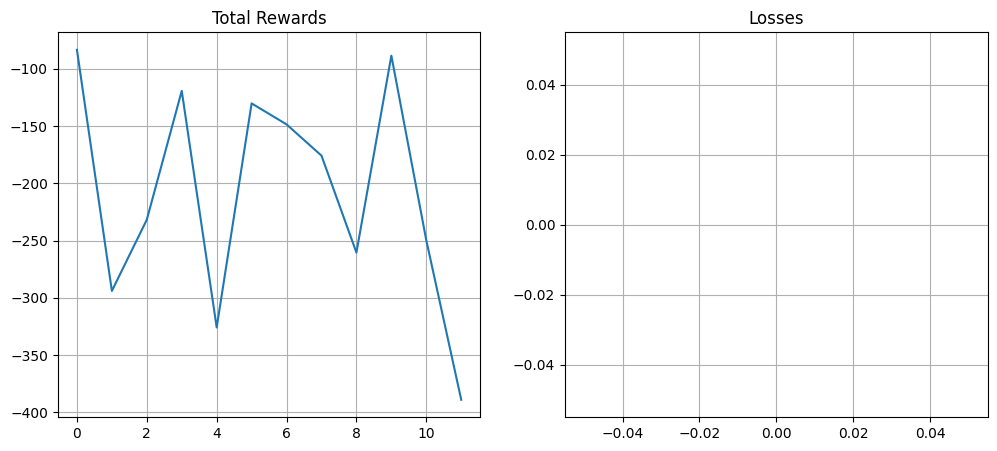

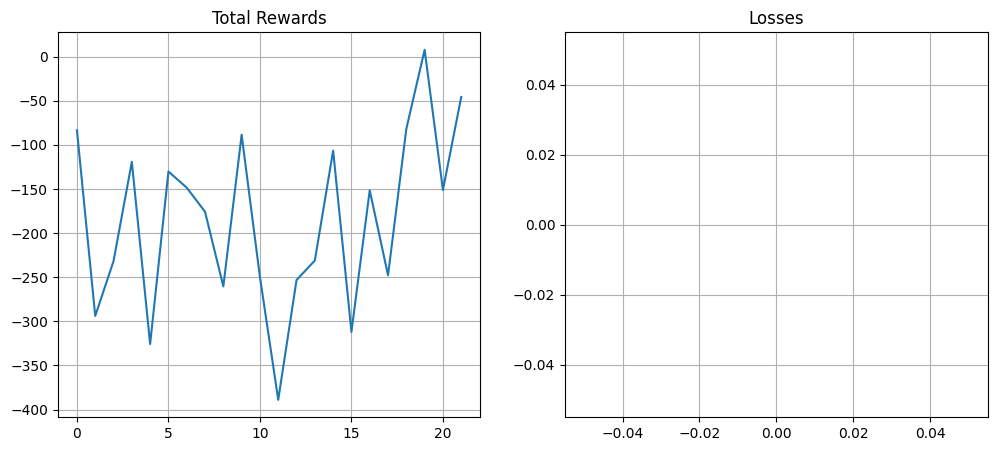

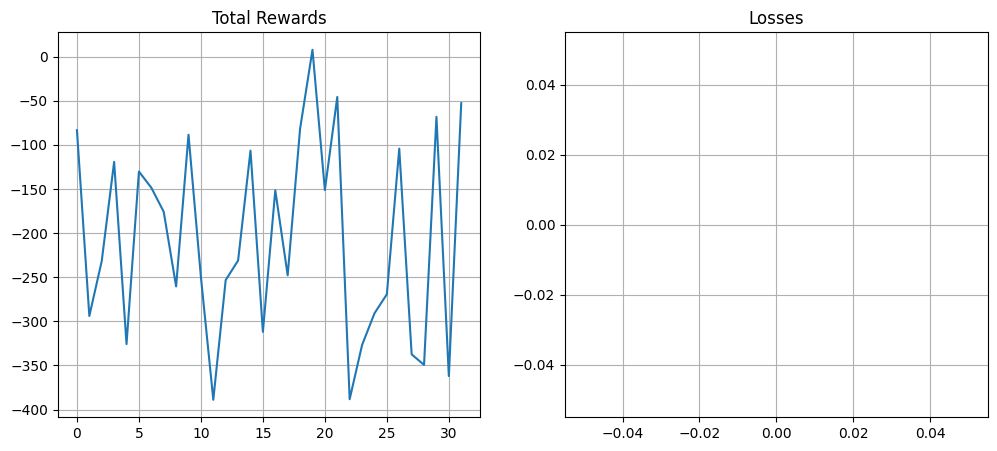

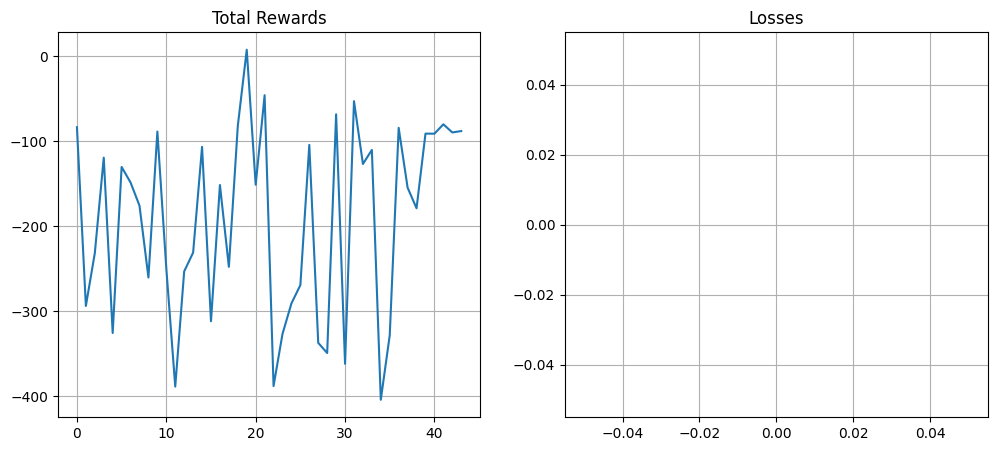

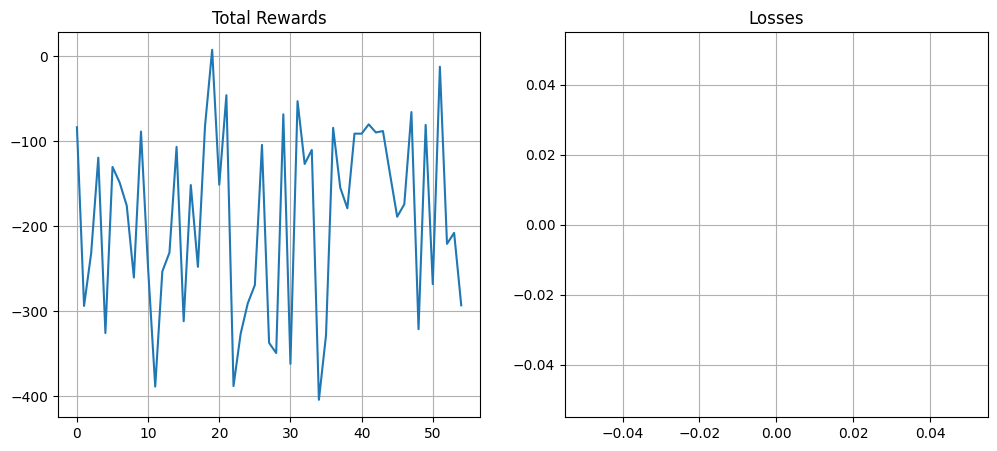

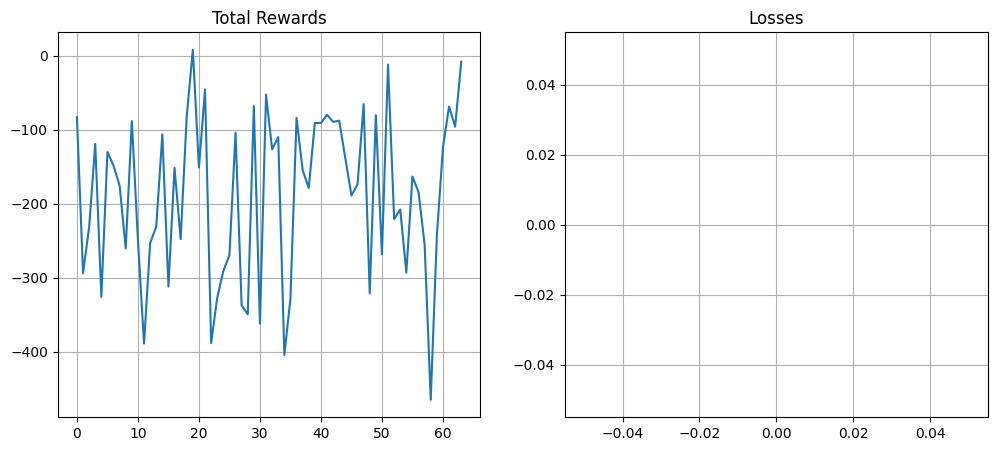

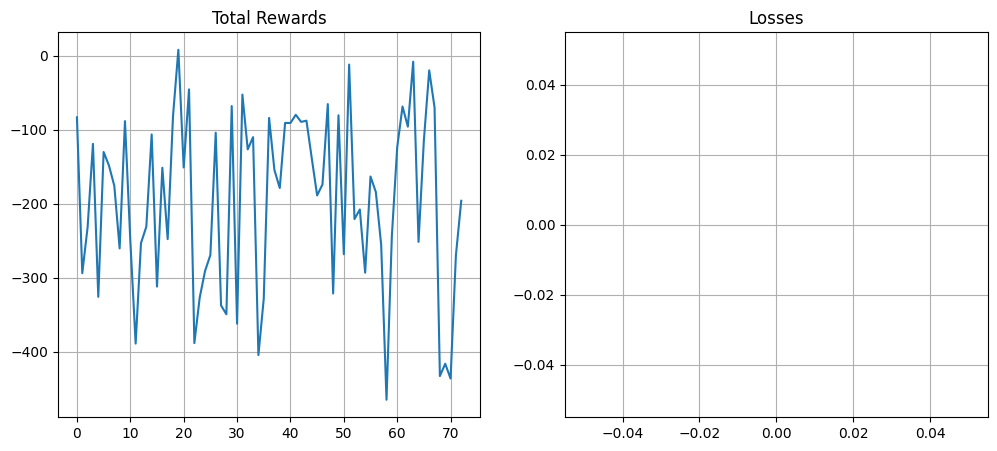

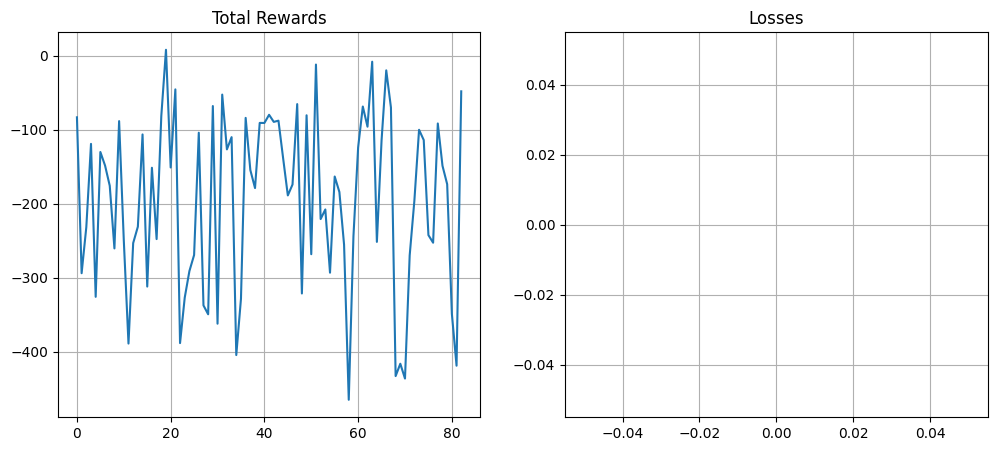

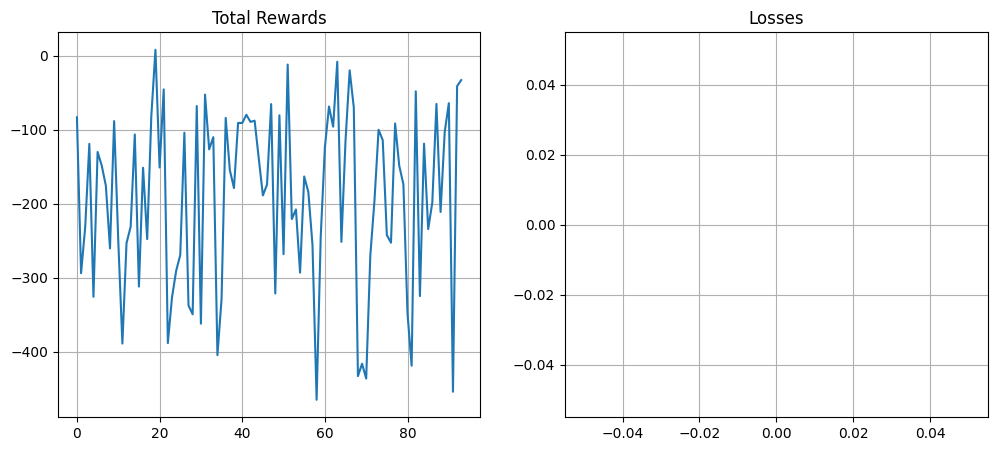

States Tensor Shape: torch.Size([32, 8]), Type: torch.float32
Actions Tensor Shape: torch.Size([32]), Type: torch.int64
Rewards Tensor Shape: torch.Size([32]), Type: torch.float32
Dones Tensor Shape: torch.Size([32, 8]), Type: torch.float32
Next States Tensor Shape: torch.Size([32]), Type: torch.float32


<ipython-input-8-e221a7aaa7bc>:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  states_v = torch.tensor(states).to(device)
<ipython-input-8-e221a7aaa7bc>:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actions_v = torch.tensor(actions).to(device)
<ipython-input-8-e221a7aaa7bc>:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rewards_v = torch.tensor(rewards).to(device)
<ipython-input-8-e221a7aaa7bc>:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach()

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x32 and 8x256)

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')

net = DQN(env.observation_space.shape[0], env.action_space.n).to(device)
tgt_net = DQN(env.observation_space.shape[0], env.action_space.n).to(device)

buffer = ExperienceBuffer(REPLAY_BUFFER_SIZE)

agent = Agent(env, buffer)

epsilon = EPSILON_START

optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)

# Lists to track total rewards and losses over training
total_rewards = []
losses = []

# Initialize time variables for tracking training time
ts = time.time()
best_mean_reward = None
obs_id = 0

while True:
    obs_id += 1
    loss_t = None  # Initialize loss_t at the beginning of each iteration

    # Update exploration rate based on epsilon decay schedule
    epsilon = max(EPSILON_FINAL, EPSILON_START - obs_id / EPSILON_DECAY_OBS)

    # Agent takes a step in the environment, receives a reward
    reward = agent.step(net, epsilon, device=device)

    if reward is not None:
        # Store total rewards and update game time
        total_rewards.append(reward)
        game_time = time.time() - ts
        ts = time.time()
        mean_reward = np.mean(total_rewards[-100:])

        if best_mean_reward is None or best_mean_reward < mean_reward:
            torch.save(net.state_dict(), './lunar_lander-best.dat')
            best_mean_reward = mean_reward
            print("GAME : {}, TIME ECLAPSED : {}, EPSILON : {}, MEAN_REWARD : {}"
                  .format(obs_id, game_time, epsilon, mean_reward))
            if best_mean_reward - mean_reward > 10:
                print("Reward {} -> {} Model Saved".format(best_mean_reward, mean_reward))

        if mean_reward > MEAN_GOAL_REWARD:
            print("SOLVED in {} obs".format(obs_id))
            break

    # Training process only if replay buffer has enough samples
    if len(buffer) >= REPLAY_MIN_SIZE:
        batch = buffer.sample(BATCH_SIZE)
        optimizer.zero_grad()
        loss_t = cal_loss(batch, net, tgt_net, device=device)
        loss_t.backward()
        optimizer.step()

        # Append the loss value to the losses list if it's computed
        if loss_t is not None:
            losses.append(loss_t.item())

    # Synchronize target network with the Q-network at regular intervals
    if obs_id % SYNC_TARGET_OBS == 0:
        tgt_net.load_state_dict(net.state_dict())

    # Plot learning curves every 1000 observations
    if obs_id % 1000 == 0:
        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        plt.title("Total Rewards")
        plt.plot(total_rewards)
        plt.grid()

        plt.subplot(1, 2, 2)
        plt.title("Losses")
        plt.plot(losses)
        plt.grid()

        plt.show()


# Visual Comparison:

write a function to render and display the environment before and after training. What visual differences do you observe in the agent's behavior? Discuss it. Also, Upload the Videos with your notebook. You can use the following library for rendering and saving videos.

In [ ]:
import imageio

# Helper function for rendering and saving a video
def render_and_save_video(env, net, episodes=10, save_path="./render_video.mp4", device="cpu"):
    frames = []
    for ep in range(episodes):
        state = env.reset()
        total_reward = 0.0
        while True:
            state_v = torch.tensor([state], dtype=torch.float32).to(device)
            q_vals = net(state_v).detach()
            action = q_vals.max(1)[1].item()

            state, reward, done, _ = env.step(action)
            total_reward += reward
            frames.append(env.render(mode="rgb_array"))

            if done:
                break

    env.close()
    imageio.mimsave(save_path, frames, fps=20)


In [ ]:
# Render and save a video before training
print("### BEFORE TRAINING ###")
render_and_save_video(env, net, device=device, save_path='./before.mp4')

# Perform the training process here

# Render and save a video after training
print("### AFTER TRAINING ###")
render_and_save_video(env, net, device=device, save_path='./after.mp4')


# Question:

Exploration (Epsilon-Greedy):

Discuss the significance of the exploration strategy, specifically the Epsilon-Greedy approach, in balancing exploration and exploitation during training.